# リポジトリクローン

In [1]:
!git clone https://github.com/xuebinqin/BASNet

Cloning into 'BASNet'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 255 (delta 66), reused 57 (delta 57), pack-reused 182
Receiving objects: 100% (255/255), 3.60 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [2]:
%cd BASNet

/content/BASNet


# 訓練済みモデルダウンロード

In [3]:
import gdown

gdown.download('https://drive.google.com/uc?id=1s52ek_4YTDRt_EOkx1FS53u-vJa0c4nu', 'basnet.pth', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1s52ek_4YTDRt_EOkx1FS53u-vJa0c4nu
To: /content/BASNet/basnet.pth
100%|██████████| 348M/348M [00:02<00:00, 135MB/s]


'basnet.pth'

In [4]:
!mkdir -p saved_models/basnet_bsi
!mv basnet.pth saved_models/basnet_bsi

# モデルロード

In [5]:
import torch

from model import BASNet

In [6]:
model = BASNet(3,1)
model.load_state_dict(torch.load('./saved_models/basnet_bsi/basnet.pth'))
model.eval().to('cpu')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

BASNet(
  (inconv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inrelu): ReLU(inplace=True)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

# ONNX変換

In [7]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['output_image']

    torch.onnx.export(
        net, 
        input, 
        file_name, 
        verbose=True,
        opset_version=13,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [9]:
# 入力画像の一辺の長さ
side_length = 256

# ONNX変換
convert_to_onnx(model, 'basnet.onnx', (side_length, side_length), 'cpu')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


graph(%input_image : Float(1, 3, 256, 256, strides=[196608, 65536, 256, 1], requires_grad=0, device=cpu),
      %outconvb.weight : Float(1, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu),
      %outconvb.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %outconv6.weight : Float(1, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu),
      %outconv6.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %outconv5.weight : Float(1, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu),
      %outconv5.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %outconv4.weight : Float(1, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %outconv4.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %outconv3.weight : Float(1, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %outconv3.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %outconv2.wei

In [10]:
!pip install onnx-simplifier

     |████████████████████████████████| 12.7 MB 4.5 MB/s 
     |████████████████████████████████| 466 kB 59.1 MB/s 
     |████████████████████████████████| 4.8 MB 45.7 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12873 sha256=dd5382510209da173c404551d4b4f8b5f92ad2ad2569e6f54339e1e683fd1786
  Stored in directory: /root/.cache/pip/wheels/0c/47/80/8eb21098e22c19d60b1c14021ee67442b4ad2d7991fdad46ba
Successfully built onnx-simplifier


In [11]:
!python -m onnxsim basnet.onnx basnet.onnx

Simplifying...
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


# 推論テスト

In [12]:
!pip install onnxruntime imread_from_url

  Created wheel for imread-from-url: filename=imread_from_url-0.1.1-py3-none-any.whl size=6456 sha256=3efe3c18dd61cb4358d9e263f920e285bf4e924536b2e97619ed32193c5ce5ff
  Stored in directory: /root/.cache/pip/wheels/ac/36/34/c633c8d8fc0b81b2579548e96877edd7679f6ab1895d2b1d23
Successfully built imread-from-url


In [13]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession('basnet.onnx')

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [14]:
from imread_from_url import imread_from_url

image = imread_from_url('https://user-images.githubusercontent.com/37477845/143690029-37eaf38f-ccdf-4b7d-b7ad-09dcabd62326.png')

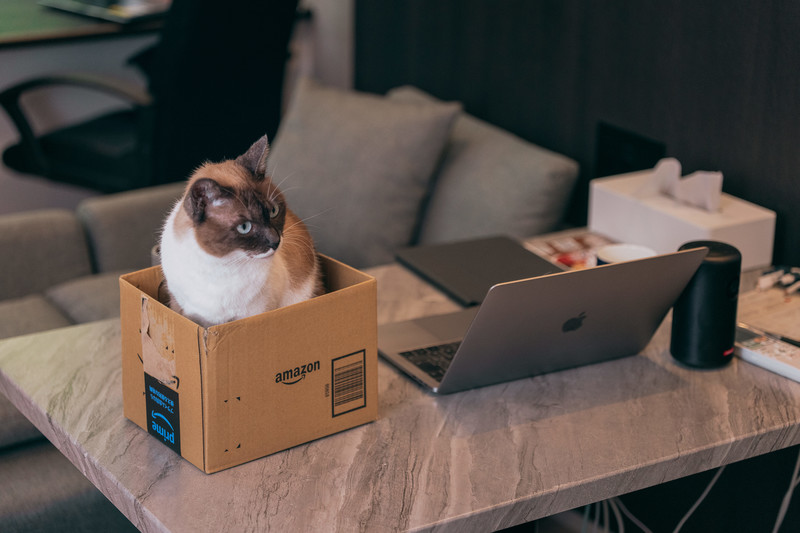

In [15]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [16]:
%%time

import cv2 as cv
import numpy as np

# 前処理
input_image = cv.resize(image, dsize=(256, 256))  # リサイズ
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # BGR→RGB変換

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (input_image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, 256, 256)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result - np.min(onnx_result)) / (np.max(onnx_result) - np.min(onnx_result))
onnx_result *= 255

CPU times: user 4.06 s, sys: 17.2 ms, total: 4.07 s
Wall time: 4.07 s


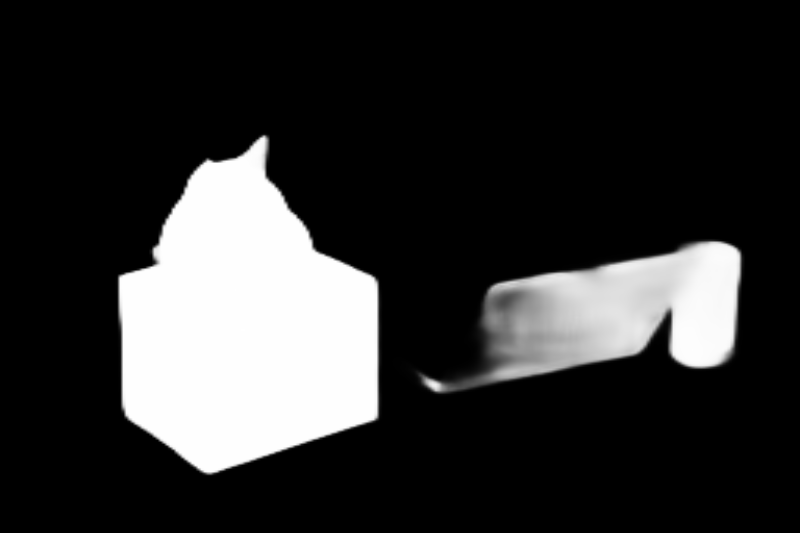

In [17]:
display_image = cv.resize(onnx_result, dsize=(image.shape[1], image.shape[0]))  # リサイズ
cv2_imshow(display_image)

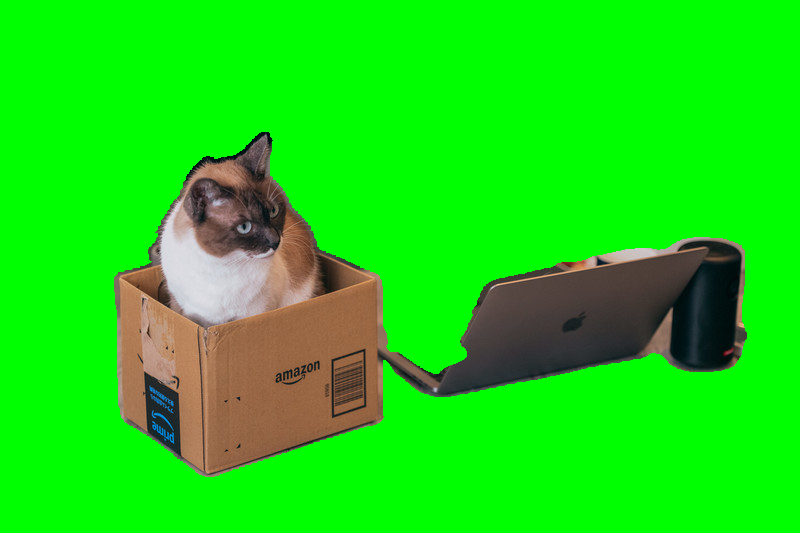

In [19]:
mask = np.where(display_image < 0.5, 1, 0)
mask = np.stack((mask, ) * 3, axis=-1).astype('uint8')

bg_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
bg_image += np.array([0, 255, 0], dtype=np.uint8)

display_image_02 = np.where(mask, bg_image, image)
cv2_imshow(display_image_02)